In [1]:
import os
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['voc2012']=(d2l.DATA_URL+'VOCtrainval_11-May-2012.tar','4e443f8a2eca6b1dac8a6c57641b67dd40621a49')
voc_dir=d2l.download_extract('voc2012','VOCdevkit/VOC2012')

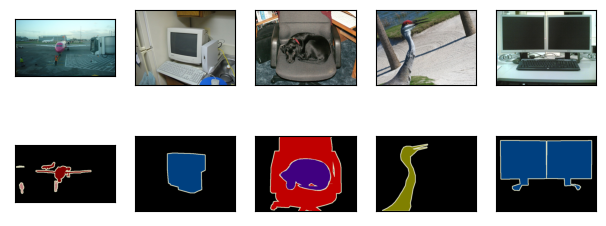

In [2]:
def read_voc_images(voc_dir,is_train=True):  #@save
    """读取所有VOC图像并标注"""
    txt_fname=os.path.join(voc_dir,'ImageSets','Segmentation','train.txt' if is_train else 'val.txt')
    mode=torchvision.io.image.ImageReadMode.RGB
    with open(txt_fname,'r') as f:
        images=f.read().split()
    features,labels=[],[]
    for i,fname in enumerate(images):
        features.append(torchvision.io.read_image(os.path.join(voc_dir,'JPEGImages',f'{fname}.jpg')))
        labels.append(torchvision.io.read_image(os.path.join(voc_dir,'SegmentationClass',f'{fname}.png'),mode))
    return features,labels

train_features,train_labels=read_voc_images(voc_dir,True)
n=5
imgs=train_features[0:n]+train_labels[0:n]
imgs=[img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs,2,n);

In [3]:
VOC_COLORMAP=[[0,0,0],[128,0,0],[0,128,0],[128,128,0],[0,0,128],[128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],[64,128,0],[192,128,0],[64,0,128],[192,0,128],[64,128,128],[192,128,128],[0,64,0],[128,64,0],[0,192,0],[128,192,0],[0,64,128]]
VOC_CLASSES=['background','aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','potted plant','sheep','sofa','train','tv/monitor']

def voc_colormap2label():   #@save
    """构建从RGB到VOC类别索引的映射"""
    colormap2label=torch.zeros(256**3,dtype=torch.long)
    for i,colormap in enumerate(VOC_COLORMAP):
        colormap2label[(colormap[0]*256+colormap[1])*256+colormap[2]]=i
    return colormap2label

def voc_label_indices(colormap,colormap2label): #@save
    """将VOC标签中的RGB值映射到它们的类别索引"""
    colormap=colormap.permute(1,2,0).numpy().astype('int32')
    idx=((colormap[:,:,0]*256+colormap[:,:,1])*256+colormap[:,:,2])
    return colormap2label[idx]

y=voc_label_indices(train_labels[2],voc_colormap2label())
y[220:230,145:155],VOC_CLASSES[9],VOC_CLASSES[12]

(tensor([[ 0, 12, 12, 12, 12, 12, 12, 12, 12, 12],
         [ 0,  0, 12, 12, 12, 12, 12, 12, 12, 12],
         [ 0,  0,  0,  0, 12, 12, 12, 12, 12, 12],
         [ 0,  0,  0,  0,  0, 12, 12, 12, 12, 12],
         [ 9,  0,  0,  0,  0,  0, 12, 12, 12, 12],
         [ 9,  9,  0,  0,  0,  0,  0, 12, 12, 12],
         [ 9,  9,  9,  0,  0,  0,  0,  0, 12, 12],
         [ 9,  9,  9,  9,  0,  0,  0,  0,  0, 12],
         [ 9,  9,  9,  9,  9,  0,  0,  0,  0,  0],
         [ 9,  9,  9,  9,  9,  9,  0,  0,  0,  0]]),
 'chair',
 'dog')

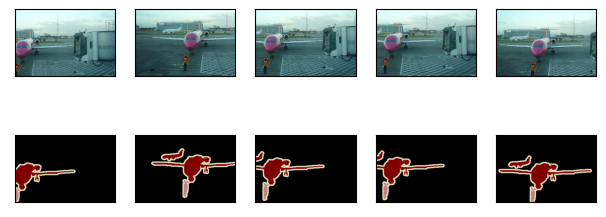

In [4]:
def voc_rand_crop(feature,label,height,width): #@save
    """随机裁剪特征和标签图像"""
    rect=torchvision.transforms.RandomCrop.get_params(feature,(height,width))
    feature=torchvision.transforms.functional.crop(feature,*rect)
    label=torchvision.transforms.functional.crop(label,*rect)
    return feature,label

imgs=[]
for _ in range(n):
    imgs+=voc_rand_crop(train_features[0],train_labels[0],200,300)
imgs=[img.permute(1,2,0) for img in imgs]
d2l.show_images(imgs[::2]+imgs[1::2],2,n);

In [5]:
class VOCSegDataSet(torch.utils.data.Dataset):    #@save
    """一个y用于加载VOC数据集的自定义数据集"""
    def __init__(self,is_train,crop_size,voc_dir):
        self.transform=torchvision.transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        self.crop_size=crop_size
        features,labels=read_voc_images(voc_dir,is_train=is_train)
        self.features=[self.normalize_image(feature) for feature in self.filter(features)]
        self.labels=self.filter(labels)
        self.colormap2label=voc_colormap2label()
        print('read '+str(len(self.features))+' examples')

    def normalize_image(self,img):
        return self.transform(img.float()/255)

    def filter(self,imgs):  # 移除尺寸小于裁剪尺寸的图像
        return [img for img in imgs if (img.shape[1]>=self.crop_size[0] and img.shape[2]>=self.crop_size[1])]
        
    def __getitem__(self,idx):
        feature,label=voc_rand_crop(self.features[idx],self.labels[idx],*self.crop_size)
        return (feature,voc_label_indices(label,self.colormap2label))

    def __len__(self):
        return len(self.features)

crop_size=(320,480)
voc_train=VOCSegDataSet(True,crop_size,voc_dir)
voc_test=VOCSegDataSet(False,crop_size,voc_dir)

read 1114 examples


In [ ]:
batch_size=64
train_iter=torch.utils.data.DataLoader(voc_train,batch_size,shuffle=True,drop_last=True,num_workers=d2l.get_dataloader_workers())
for X,Y in train_iter:
    print(X.shape)
    print(Y.shape)
    break

In [ ]:
def load_data_voc(batch_size,crop_size):    #@save
    """加载VOC语义分割数据集"""
    voc_dir=d2l.download_extract('voc2012',os.path.join('VOCdevkit','VOC2012'))
    num_workers=d2l.get_dataloader_workers()
    train_iter=torch.utils.data.DataLoader(VOCSegDataSet(True,crop_size,voc_dir),batch_size,shuffle=True,drop_last=True,num_workers=num_workers)
    test_iter=torch.utils.data.DataLoader(VOCSegDataSet(False,crop_size,voc_dir),batch_size,drop_last=True,num_workers=num_workers)
    return train_iter,test_iter